### Regression-based analysis of Apple and Microsoft stocks ###

Is it possible to derive any relationship between the behavior of two stocks? Through this problem, I have tried to show how regression can be used to understand the behavior of Apple and Microsoft stocks and if there truly is any trace of co-dependedence.

In [1]:
import pandas as pd
import numpy
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
#Wanted to increase the font size of my graphs

params={
    "font.size":15
}
plt.rcParams.update(params)

#### I downloaded the historical ticker prices of Apple and Microsoft from https://finance.yahoo.com/. ###

In [3]:
msft_file = pd.read_csv('MSFT.csv')
aapl_file = pd.read_csv('AAPL.csv')

In [4]:
msft_file.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-29,108.110001,108.699997,100.110001,106.160004,104.517632,242639700
1,2018-11-05,106.370003,112.239998,105.900002,109.570000,107.874870,147847300
2,2018-11-12,109.419998,109.959999,103.910004,108.290001,106.614677,180498800
3,2018-11-19,108.269997,108.559998,99.349998,103.070000,101.913811,150780100
4,2018-11-26,104.790001,111.330002,104.580002,110.889999,109.646095,170038000


In [5]:
aapl_file.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-29,219.190002,222.360001,205.429993,207.479996,204.309570,270606300
1,2018-11-05,204.300003,210.119995,198.169998,204.470001,201.345581,191199400
2,2018-11-12,199.000000,199.850006,185.929993,193.529999,191.237686,242226500
3,2018-11-19,190.000000,190.699997,172.100006,172.289993,170.249252,164498700
4,2018-11-26,174.240005,182.800003,170.259995,178.580002,176.464767,213749900


In [6]:
aapl = 'AAPL'
msft = 'MSFT'

#### Adj Close: ##
An adjusted closing price is a stock's closing price on any given day of trading that has been amended to include any distributions and corporate actions that occurred at any time prior to the next day.

In [7]:
#Extracting the adjusted closing prices from both the stocks

def extractdata(stock):
    data = pd.read_csv(stock+".csv", index_col = 0)
    data.index = pd.to_datetime(data.index)
    data_series = pd.Series(data["Adj Close"], name = stock)
    return data_series.copy()

adj_aapl = extractdata(aapl)
adj_msft = extractdata(msft)

print(adj_aapl.head())
print(adj_msft.head())

Date
2018-10-29    204.309570
2018-11-05    201.345581
2018-11-12    191.237686
2018-11-19    170.249252
2018-11-26    176.464767
Name: AAPL, dtype: float64
Date
2018-10-29    104.517632
2018-11-05    107.874870
2018-11-12    106.614677
2018-11-19    101.913811
2018-11-26    109.646095
Name: MSFT, dtype: float64


In [8]:
#Merging the two into one table

prices = pd.concat([adj_aapl, adj_msft], axis="columns", join="outer")
prices.head()

,AAPL,MSFT
Date,,
2018-10-29,204.309570,104.517632
2018-11-05,201.345581,107.874870
2018-11-12,191.237686,106.614677
2018-11-19,170.249252,101.913811
2018-11-26,176.464767,109.646095


In [9]:
#Now we need a table with only the returns from both stocks

temp_a  = prices.shift()
temp_b = (prices/temp_a)-1
returns = temp_b.dropna()
returns.head()

,AAPL,MSFT
Date,,
2018-11-05,-0.014507,0.032121
2018-11-12,-0.050202,-0.011682
2018-11-19,-0.109751,-0.044092
2018-11-26,0.036508,0.075871
2018-12-03,-0.056501,-0.054739


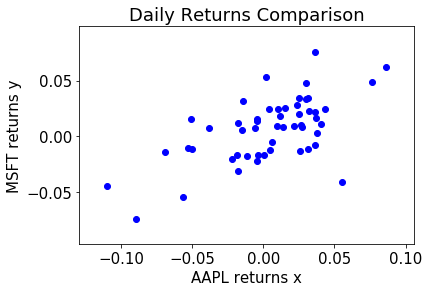

In [10]:
#Let's graph this

plt.figure()
plt.scatter(returns[aapl], returns[msft], color="blue")
plt.xlabel(aapl + " returns x")
plt.ylabel(msft + " returns y")
plt.title("Daily Returns Comparison")
plt.show()
plt.close()

In [11]:
#This is where we are going to go back in and do our linear regression functions. We name them x and y so that we can use easier names for data functions.

data_1 = 100*returns.rename(columns={aapl:"x",msft:"y"})
data_2 = 100*returns.rename(columns={msft:"x",aapl:"y"})

In [12]:
#Creating a refression class that will help us regress both Apple and Microsoft values

class Regression:
    def __init__(self, data):
        self.xvals = data["x"]
        self.yvals = data["y"]
        self.reset()
        
    def reset(self):
        self.ctr = 0
        self.callbacktext = []
        
    def make_linear_function(self, m, b):
        def linear_function(x):
            return m*x+b
        return linear_function
    
    def Err(self, x):
        (m,b) = x
        linear_function = self.make_linear_function(m,b)
        err = self.yvals - linear_function(self.xvals)
        return 0.5*numpy.mean(err**2)
    
    def Err_grad(self,x):
        (m,b)=x
        linear_function=self.make_linear_function(m,b)
        err=self.yvals-linear_function(self.xvals)
        out=numpy.array([-numpy.mean(self.xvals*err),-numpy.mean(err)])
        return out
    
    def callback(self,x,verbose=False):
        (m,b)=x
        outstr="ctr={0:}; (m,b)=({1:.3f},{2:.2E}); error={3:.2E}".format(self.ctr,m,b,self.Err(x))
        self.callbacktext.append(outstr)
        if verbose:
            print(outstr)
        self.ctr+=1

In [13]:
firstregression = Regression(data_1)
secondregression = Regression(data_2)

In [14]:
bestline_1 = minimize(firstregression.Err,[0,0],callback=firstregression.callback)
(m_best1,b_best1) = bestline_1["x"]
print("m1={0:}; b1={1:}".format(m_best1,b_best1))

bestline_2 = minimize(secondregression.Err,[0,0],callback=secondregression.callback)
(m_best2,b_best2) = bestline_2["x"]
print("m2={0:}; b2={1:}".format(m_best2,b_best2))

m1=0.45998987558774235; b1=0.45194449270437365
m2=0.8192838028636809; b2=-0.08686779037760307


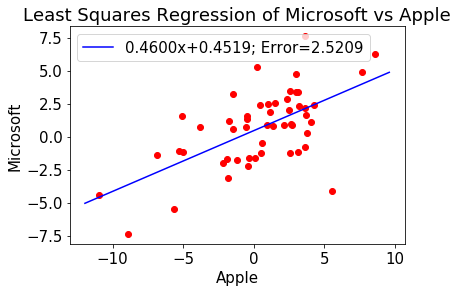

In [15]:
plt.figure()
plt.scatter(data_1["x"],data_1["y"],label=None,color="red")
plt.xlabel("Apple")
plt.ylabel("Microsoft")
xlims=numpy.array(plt.gca().get_xlim())
plt.plot(xlims,m_best1*xlims+b_best1,color="blue",label="{0:.4f}x{1:+.4f}; Error={2:.4f}".format(m_best1,b_best1,firstregression.Err((m_best1,b_best1))))
plt.legend()
plt.title("Least Squares Regression of Microsoft vs Apple")
plt.show()
plt.close()

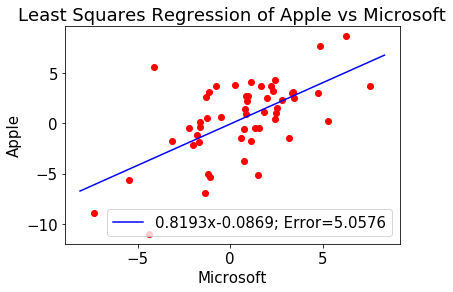

In [16]:
plt.figure()
plt.scatter(data_2["x"],data_2["y"],label=None,color="red")
plt.ylabel("Apple")
plt.xlabel("Microsoft")
xlims=numpy.array(plt.gca().get_xlim())
plt.plot(xlims,m_best2*xlims+b_best2,color="blue",label="{0:.4f}x{1:+.4f}; Error={2:.4f}".format(m_best2,b_best2,secondregression.Err((m_best1,b_best1))))
plt.legend()
plt.title("Least Squares Regression of Apple vs Microsoft")
plt.show()
plt.close()

## Solution

From what we've observed, it can be concluded that the Microsoft prices drive the Apple prices more than the opposite. Be using the Least Squares Regression technique, we found that the slope of Apple vs Microsoft (0.8193) is clearly greater than the slope of Microsoft vs Apple (0.4600). Changes in Microsoft's price will affect Apple's price more than the other way round.